In [1]:
from tqdm import tqdm, trange
from time import time
from scipy.interpolate import interp1d
from libsvm.svmutil import svm_read_problem # https://blog.csdn.net/u013630349/article/details/47323883

import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


%matplotlib inline

## Plot funcs

In [2]:
def plot_single(seq, xlabel='Iteration', ylabel='Gradient Norm', title=''):
    plt.figure()
    iterations = np.arange(len(seq))+1
    plt.semilogy(iterations,seq)
    plt.xticks(iterations)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# 
def plot_multi_seqs(seqs, xlabel='Iteration', ylabel='Gradient Norm', title='', xtick_step = 50):
    plt.figure(figsize=(16,8), dpi=150)
    maxLen = 0
    for seq in seqs:
        iterations = seq.index
        if iterations.size > maxLen:
            maxLen = iterations.size
        plt.semilogy(iterations, seq, label=seq.name)
    plt.xticks(np.arange(stop=maxLen,step=xtick_step)+1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## Data Reader

In [5]:
def read_data(path):
    b, A = svm_read_problem(path)
    rows = len(b)   # 矩阵行数, i.e. sample 数
    cols = max([max(row.keys()) if len(row)>0 else 0 for row in A])  # 矩阵列数, i.e. feature 数
    b = np.array(b)
    A_np = np.zeros((rows,cols))
    for r in range(rows):
        for c in A[r].keys():
            # MatLab 是 1-index, python 则是 0-index
            A_np[r,c-1] = A[r][c]
    # 清楚全 0 features
    effective_row_ids = []
    for idx, row in enumerate(A_np):
        if np.sum(row) > 1e-3:
            effective_row_ids.append(idx)
    return b[effective_row_ids], A_np[effective_row_ids]

# b, A = read_data('w8a')
b, A = read_data('covtype.libsvm.binary.scale')
# convert +1,+2 to -1,+1
b = 2*b-3
m,n = A.shape
m,n

(581012, 54)

## Related func

In [56]:
lamda = 100

def f(x):
    bAx = b*(A@x)
    exp_mbAx = np.exp(-bAx)
    log1p_exp = np.log(1+exp_mbAx)
    overflow_idxs = np.where(exp_mbAx==float('inf'))
    log1p_exp[overflow_idxs] = -bAx[overflow_idxs]
    # return np.log(1+np.exp(-bAx)).mean() + 1/(100*m)* x.T@x
    return log1p_exp.mean() + 1/(lamda*m)* x.T@x

def f_grad(x):
    # return np.ones(m)@(np.expand_dims((-b)/(1+np.exp(b*(A@x))), axis=1)*A)/m
    return np.ones(m)@(np.expand_dims((-b)/(1+np.exp(b*(A@x))), axis=1)*A)/m + 2/(lamda*m)*x

def f_hessian(x):
    Ax = A@x
    exp_bAx = np.exp(b*Ax)
    # return (A.T @ (np.expand_dims(b*b*exp_bAx/(1+exp_bAx)**2, axis=1)*A) )/m
    # return (A.T @ (np.expand_dims(b*b*exp_bAx/(1+exp_bAx)**2, axis=1)*A) )/m + 2/(lamda*m)*np.diag([1.0]*x.size)
    return (A.T @ (np.expand_dims(b*b*exp_bAx/(1+exp_bAx)**2, axis=1)*A) )/m + 2/(lamda*m)*np.eye(x.size)

#* Armijo rule 
def armijo_search(f, f_grad, xk, t_hat, alpha, beta, D, isNewton=False, dk=None):
    if isNewton:
        assert dk is not None
    tk = t_hat*1
    grad = f_grad(xk)
    while True:
        if isNewton:
            if np.linalg.norm(xk+tk*dk,ord=2)<=D/2 and f(xk+tk*dk) <= f(xk) + alpha*tk*grad.T@dk:
                break
        else:
            if f(xk-tk*grad) <= f(xk)-alpha*tk*grad.T@grad:
                break
        tk *= beta
    return tk

#* pure阻尼牛顿
def pure_damped_newton(f, f_grad, f_hessian, x0, D, epsilon=1e-6, max_iters=100):
    func_val_record = []
    grad_norm_record = []
    xk = x0
    t_s = time()
    # for idx in trange(max_iters):
    for idx in range(max_iters):
        grad = f_grad(xk)
        # print(np.linalg.norm(grad))
        hessian = f_hessian(xk)
        # dk = -np.linalg.pinv(hessian)@grad
        dk = -np.linalg.inv(hessian)@grad
        tk = armijo_search(f, f_grad, xk, t_hat=1, alpha=0.1, beta=0.5, D=D, isNewton=True, dk=dk)
        xk_next = xk + tk*dk
        func_val_record.append(f(xk_next))
        # grad_norm_record.append(np.linalg.norm(f_grad(xk_next),ord=2))
        grad_next = np.linalg.norm(f_grad(xk_next),ord=2)
        grad_norm_record.append(grad_next)
        # termination criteria
        if grad_next<=epsilon:
            break
        else:
            print('grad_norm:',grad_next,"tk:",tk, "x_norm:",np.linalg.norm(xk_next))
        xk = xk_next
    t_e = time()
    return xk_next, np.asarray(func_val_record), np.asarray(grad_norm_record), t_e-t_s

np.random.seed(1000)

# init_x = np.zeros(n)+0.5
init_x = np.ones(n)

# D=500 半径足够大，本质上是无约束
x_opt_damped, _, _, t_damped = pure_damped_newton(f=f, f_grad=f_grad, f_hessian=f_hessian, x0=init_x, D=500, epsilon=1e-8, max_iters=100)
print(f'最小值: {f(x_opt_damped):>2f}\t耗时: {t_damped:>2f}s')

grad_norm: 0.08530975861519442 tk: 0.015625 x_norm: 34.964920630103336
grad_norm: 0.057001361043605 tk: 0.25 x_norm: 155.7611859970194
grad_norm: 0.03699938262479159 tk: 0.0625 x_norm: 100.56327838167698
grad_norm: 0.03485763697171587 tk: 0.0625 x_norm: 44.18161487837228
grad_norm: 0.034156889081627256 tk: 0.015625 x_norm: 28.00275960423564
grad_norm: 0.03378083412038892 tk: 0.015625 x_norm: 21.83138317165476
grad_norm: 0.03336032352269626 tk: 0.0078125 x_norm: 23.076408214231577
grad_norm: 0.0332005216868126 tk: 0.0078125 x_norm: 18.109180797790682
grad_norm: 0.01014817745097118 tk: 1 x_norm: 16.000117172877445
grad_norm: 0.0027332536967410786 tk: 1 x_norm: 18.22274599336087
grad_norm: 0.0005619215680205569 tk: 1 x_norm: 19.51312992867872
grad_norm: 0.00010185881697930222 tk: 1 x_norm: 20.60621239539543
grad_norm: 2.588996952022959e-05 tk: 1 x_norm: 21.568666700036864
grad_norm: 8.989288542734788e-06 tk: 1 x_norm: 22.43722933284627
grad_norm: 2.950750980092227e-06 tk: 1 x_norm: 23.203

In [40]:
np.linalg.norm(x_opt_damped)

24.106052860980544

## Stochastic Gradient Descent

### Projected Gradient Descent

In [58]:
lamda = 100

def f(x,A,b):
    m,n = A.shape
    bAx = b*(A@x)
    exp_mbAx = np.exp(-bAx)
    log1p_exp = np.log(1+exp_mbAx)
    overflow_idxs = np.where(exp_mbAx==float('inf'))
    log1p_exp[overflow_idxs] = -bAx[overflow_idxs]
    return log1p_exp.mean() + 1/(lamda*m)* x.T@x

def f_grad(x,A,b):
    m,n = A.shape
    return np.ones(m)@(np.expand_dims((-b)/(1+np.exp(b*(A@x))), axis=1)*A)/m + 2/(lamda*m)*x

def f_hessian(x,A,b):
    m,n = A.shape
    Ax = A@x
    exp_bAx = np.exp(b*Ax)
    return (A.T @ (np.expand_dims(b*b*exp_bAx/(1+exp_bAx)**2, axis=1)*A) )/m + 2/(lamda*m)*np.eye(x.size)


def data_generator(A, b, batch_size=8192):
    m,n = A.shape
    new_idxs = np.arange(m)
    np.random.shuffle(new_idxs)
    A = A[new_idxs]
    b = b[new_idxs]
    numBatches = m//batch_size+1
    for i in range(numBatches):
        idx_begin = i*batch_size
        idx_end = (i+1)*batch_size
        yield (A[idx_begin:idx_end], b[idx_begin:idx_end])

def project(x,D):
    x_norm = np.linalg.norm(x)
    if x_norm <= D/2:
        return x
    coef = D/2/x_norm
    return coef*x

#* 投影梯度法
def projected_sgd(f, f_grad, x0, D, t_hat=1, epsilon=1e-6, batch_size=8192, epochs=50):
    func_val_record = []
    xk = x0
    xk_norm = np.linalg.norm(xk)
    t_s = time()
    for epoch in range(epochs):
        for batch_A, batch_b in data_generator(A, b, batch_size):    
            tk = armijo_search(f=lambda x:f(x,batch_A,batch_b), f_grad=lambda x:f_grad(x,batch_A,batch_b), 
                                xk=xk, t_hat=t_hat, alpha=0.1, beta=0.5, D=D)
            xk_next = project(xk-tk*f_grad(xk,batch_A,batch_b), D)
            norm_diff = np.linalg.norm(xk_next-xk)
            if norm_diff<=epsilon:
                break
            xk = xk_next
        fval = f(xk,A,b)
        grad_norm = np.linalg.norm(f_grad(xk,A,b))
        func_val_record.append(fval)
        print(f'Epoch {epoch} - Grad. Norm.:',grad_norm, 'F val.:',fval, 'Norm. Diff.:',norm_diff, 'x_norm:', np.linalg.norm(xk))
    t_e = time()
    return xk_next, np.asarray(func_val_record), t_e-t_s

np.random.seed(1000)
# init_x = np.zeros(n)+0.005
# init_x = np.zeros(n)+0.5
init_x = np.ones(n)
# x_opt_spgd, _, t_spgd = projected_sgd(f=f, f_grad=f_grad, x0=init_x, D=500, t_hat=5, epsilon=1e-4, epochs=100)
x_opt_spgd, fvals_spgd, t_spgd = projected_sgd(f=f, f_grad=f_grad, x0=init_x, D=500, t_hat=5, epsilon=1e-4, epochs=100)
print(f'最小值: {f(x_opt_spgd,A,b):>2f}\t耗时: {t_spgd:>2f}s')

Epoch 0 - Grad. Norm.: 0.026112416570798644 F val.: 0.5653209355585493 Norm. Diff.: 0.05774760893423627 x_norm: 7.579608032463021
Epoch 1 - Grad. Norm.: 0.009121114240783166 F val.: 0.5466603838255097 Norm. Diff.: 0.0695109078315108 x_norm: 8.700006685457705
Epoch 2 - Grad. Norm.: 0.02559250247600782 F val.: 0.5385414694623275 Norm. Diff.: 0.0667965444646806 x_norm: 9.547078150091641
Epoch 3 - Grad. Norm.: 0.01342260867133906 F val.: 0.5326281456315046 Norm. Diff.: 0.060005850493295175 x_norm: 10.285761119978561
Epoch 4 - Grad. Norm.: 0.0069613488556752355 F val.: 0.5285827348986782 Norm. Diff.: 0.041910558479783255 x_norm: 10.953970540462684
Epoch 5 - Grad. Norm.: 0.01492594344904571 F val.: 0.5262010925028356 Norm. Diff.: 0.043555112899375796 x_norm: 11.476058886064141
Epoch 6 - Grad. Norm.: 0.006091237435683182 F val.: 0.5241651456871017 Norm. Diff.: 0.03648260902420379 x_norm: 11.93181452195806
Epoch 7 - Grad. Norm.: 0.006590065012424258 F val.: 0.5227524363618165 Norm. Diff.: 0.03

In [59]:
f(x_opt_spgd,A,b)-f(x_opt_damped,A,b)

0.000445531511990116

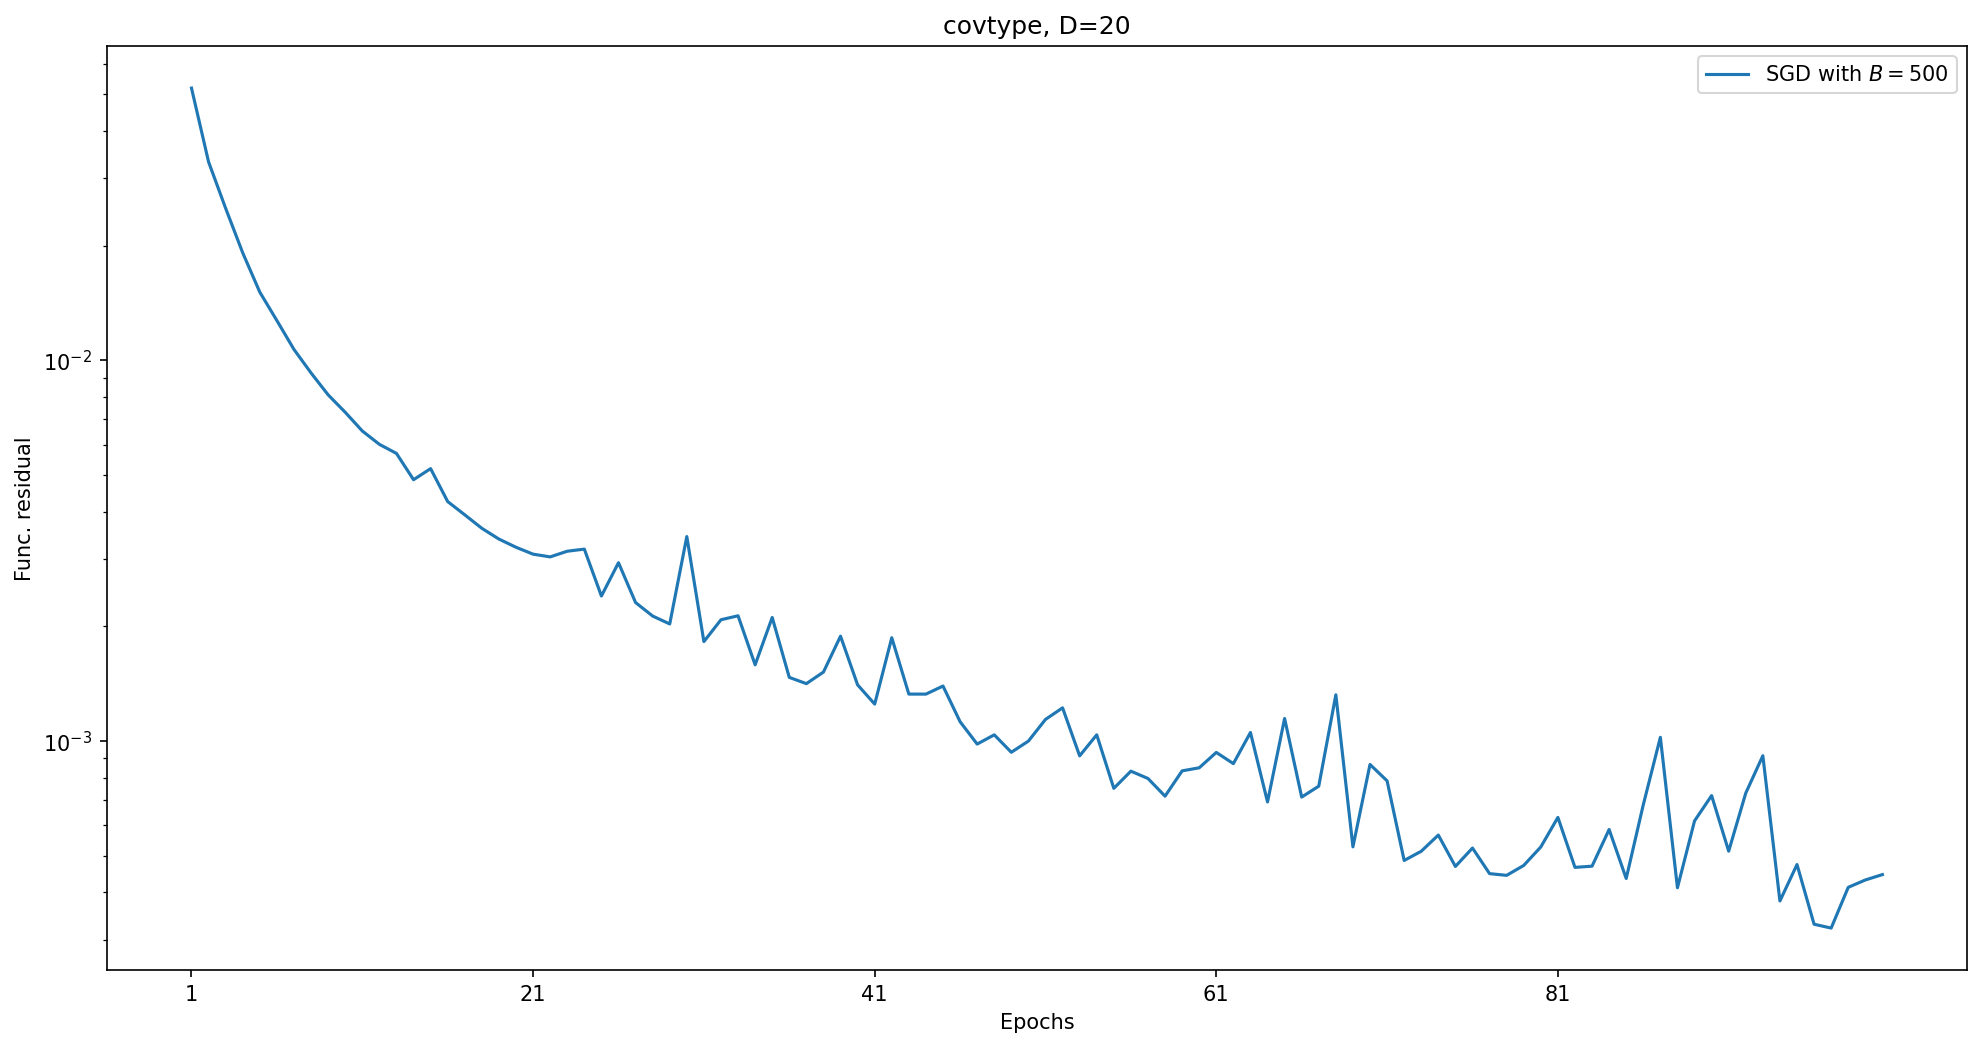

In [68]:
fvals_spgd_seq = pd.Series(fvals_spgd-f(x_opt_damped,A,b), index=np.arange(len(fvals_spgd))+1, name=r'SGD with $B=500$')
plot_multi_seqs([fvals_spgd_seq], xlabel='Epochs', ylabel=r'Func. residual', title=r'covtype, D=20', xtick_step = 20)
